### Fun with Gamma Ray Bursts.

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research here!). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import sklearn
from tqdm import tqdm
from astropy.visualization.hist import hist as fancyhist
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift
import corner
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

plt.rcParams['font.size']=16 
plt.rcParams['font.family']='Liberation Serif' 
plt.rcParams['figure.autolayout']=True 
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['figure.figsize']=(8,5) 

In [2]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])
    
print(names)

['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


In [3]:
#remove undetected T90 from the data
T90_unclean = np.array(data[6], dtype = float)
z_unclean = np.array(data[11], dtype = float)
fluence_unclean = np.array(data[9], dtype = float)

T90 = np.log10(np.array(data[6][T90_unclean != -999], dtype = float))
z = np.array(data[11][z_unclean > 0], dtype = float)

In [4]:
import seaborn as sns
from bokeh.plotting import *
from bokeh.models import ColumnDataSource

# output to static HTML file
output_file("linked_brushing.html")

condition = (T90_unclean != -999) & (z_unclean > 0) & (fluence_unclean != -999)
T90_new = np.log10(T90_unclean[condition])
z_new = z_unclean[condition]
fluence_new = np.log10(fluence_unclean[condition])
GRB_name = data[0][condition]

# NEW: create a column data source for the plots to share
source = ColumnDataSource(data=dict(logT90=T90_new, z=z_new, 
                                    fluence=fluence_new, GRB_name = GRB_name))

TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select,lasso_select"

TOOLTIPS = [
    ("index", "$index"),
    ("(x,y)", "($x, $y)"), 
    ("GRB_name", "@GRB_name")
]

# create a new plot and add a renderer
left = figure(tools=TOOLS, tooltips=TOOLTIPS,
              width=350, height=350, title=None,
              x_axis_label ="logT90",
              y_axis_label ="z")
left.circle('logT90', 'z', source=source)

# create another new plot and add a renderer
center = figure(tools=TOOLS, tooltips=TOOLTIPS,
               width=350, height=350, title=None,
               x_axis_label ="logT90",
               y_axis_label ="fluence")
center.circle('logT90', 'fluence', source=source)

# create another new plot and add a renderer
right = figure(tools=TOOLS, tooltips=TOOLTIPS,
               width=350, height=350, title=None,
               x_axis_label ="z",
               y_axis_label ="fluence")
right.circle('z', 'fluence', source=source)

# put the subplots in a gridplot
p = gridplot([[left, center, right]])

# show the results
show(p,browser="firefox")

Text(0.5, 0, 'z')

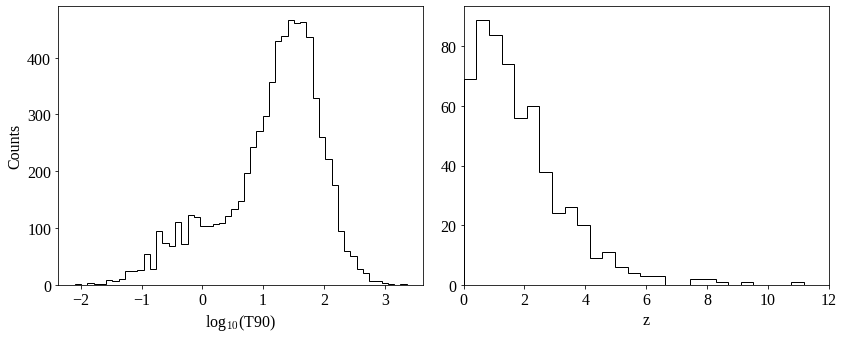

In [5]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

#plot the data
a0 = fancyhist(T90, bins = 'freedman', density = True, histtype = 'step', color = 'w');
ax[0].hist(T90, bins = a0[1], histtype = 'step', color = 'k');
ax[0].set_xlabel(r'log$_{10}$(T90)')
ax[0].set_ylabel('Counts')

a1 = fancyhist(z, bins = 'freedman', density = True, histtype = 'step', color = 'w');
ax[1].hist(z, bins = a1[1], histtype = 'step', color = 'k');
ax[1].set_xlim(0, 12)
ax[1].set_xlabel(r'z')

Since the multimodality seems to be more evident in the T90 value, I chose to use only this quantity for the clustering. This is done because the condition of correctly measured redshift reduce the dataset size of $\sim$ 1/5

In [99]:
#estimate the KDE

#find the optimal binwidth with cross-validation
bwrange = np.linspace(1e-2, 1, 100) 
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K, n_jobs=-1) # Try each bandwidth with K-folds
grid.fit(T90[:, np.newaxis]) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['bandwidth']
print('Optimal bandwidth =', h_opt)

Optimal bandwidth = 0.12


Text(0, 0.5, 'Density')

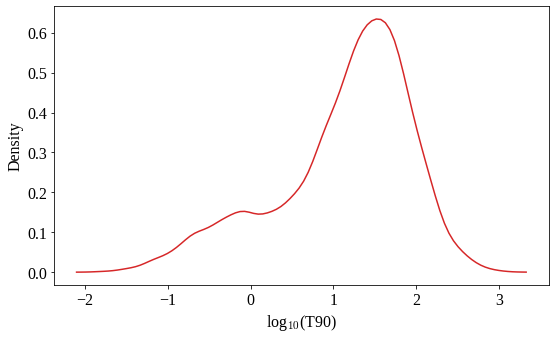

In [7]:
#evaluate and plot the KDE
def kde_sklearn(data, bandwidth):
    kde_skl = KernelDensity(bandwidth = bandwidth)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)
    return np.exp(log_pdf)

xgrid =np.linspace(np.min(T90),np.max(T90),100)
pdf = kde_sklearn(T90, bandwidth=h_opt)
plt.plot(xgrid,pdf,c='tab:red')
plt.xlabel(r'log$_{10}$(T90)')
plt.ylabel(r'Density')

### Try KMeans clustering

In [11]:
X = T90[:, np.newaxis]

clf = KMeans(n_clusters=2)          #Try 2 clusters
clf.fit(X)
centers_km = clf.cluster_centers_   #location of the clusters
labels_km = clf.predict(X)          #labels for each of the points

if centers_km[0] > centers_km[1]:
    centers_km = centers_km[::-1]
    labels_km = np.array(~np.array(labels_km,dtype='bool'),dtype='int') 
    
thr_km = np.max(X[labels_km == 0])  #threshold between the clusters

### Try Mean-shift clustering 

In [14]:
bandwidth = estimate_bandwidth(X)

scaler = preprocessing.StandardScaler()     #Standardize features by removing the mean and scaling to unit variance
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False)
ms.fit(scaler.fit_transform(X))

centers_ms = scaler.inverse_transform(ms.cluster_centers_) #bring back to original representation
labels_ms = ms.predict(scaler.transform(X)) #labels for each of the points

if centers_ms[0] > centers_ms[1]:
    centers_ms = centers_ms[::-1]
    labels_ms = np.array(~np.array(labels_ms,dtype='bool'),dtype='int')
    
thr_ms = np.max(X[labels_ms == 0])          #threshold between the clusters

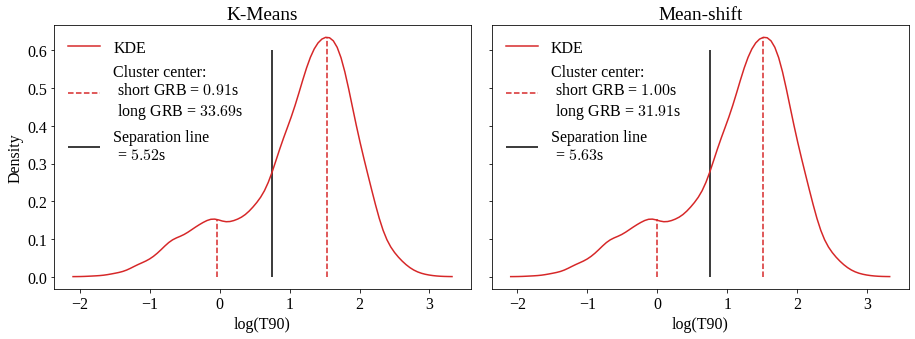

In [15]:
#plot the results
fig, axs = plt.subplots(1, 2, figsize=(13, 5), sharey=True)
axs[0].set_title('K-Means')
axs[1].set_title('Mean-shift')
axs[0].set_ylabel(r'Density')

for ax, center, thr in zip(axs, [centers_km, centers_ms], [thr_km, thr_ms]):
    ax.plot(xgrid,pdf,c='tab:red', label = 'KDE')
    ax.vlines(x =  center[0], ymin = 0, ymax = np.max(pdf[xgrid<0]), color = 'tab:red', linestyle = '--', label = 'Cluster center: \n short GRB = $%.2f$s \n long GRB = $%.2f$s' %tuple(10**center))
    ax.vlines(x =  center[1], ymin = 0, ymax = np.max(pdf), color = 'tab:red', linestyle = '--')
    ax.vlines(x =  thr, ymin = 0, ymax = 0.6, color = 'k', label = 'Separation line \n = $%.2f$s' % 10**thr)
    ax.legend(frameon=False)
    ax.set_xlabel(r'log(T90)')

In [16]:
#print values and relative differences in the values estimated with the two methods
print(f'Center of short GRB: K-Means =  {centers_km[0, 0]:.3f}  , Mean-shift = {centers_ms[0, 0]:.3f} , relative difference = {(2*(10**(centers_km[0])-10**(centers_ms[0]))/(10**(centers_km[0])+10**(centers_ms[0])))[0]:.3f}')
print(f'Center of long GRB: K-Means =  {centers_km[1, 0]:.3f}  , Mean-shift = {centers_ms[1, 0]:.3f} , relative difference = {(2*(10**(centers_km[1])-10**(centers_ms[1]))/(10**(centers_km[1])+10**(centers_ms[1])))[0]:.3f}')
print(f'Threshold: K-Means =  {10**(thr_km):.3f}  , Mean-shift = {10**(thr_ms):.3f} , relative difference = {2*(10**(thr_km)-10**(thr_ms))/(10**(thr_km)+10**(thr_ms)):.3f}')

Center of short GRB: K-Means =  -0.039  , Mean-shift = -0.001 , relative difference = -0.087
Center of long GRB: K-Means =  1.527  , Mean-shift = 1.504 , relative difference = 0.054
Threshold: K-Means =  5.520  , Mean-shift = 5.632 , relative difference = -0.020


In [17]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(labels_ms,labels_km)
print(C)

[[1796   15]
 [   0 5176]]


### Try fit with a two gaussian model to take into account for the uncertainties 

In [18]:
T90_unclean = np.array(data[6], dtype = float)
T90err_unclean = np.array(data[7], dtype = float)

condition = (T90_unclean != -999) & (T90err_unclean > 0)

T90 = np.array(data[6][condition], dtype = float)
T90_err = np.array(data[7][condition], dtype = float)

In [20]:
T90 = np.log10(np.array(data[6][condition], dtype = float))
T90_err = np.array(data[7][condition], dtype = float)/(10**(T90)*np.log(10))

def logLike(par, x, e):
    
    A, mu1, sigma1, mu2, sigma2 = par
    
    s1 = sigma1** 2 + e** 2
    s2 = sigma2** 2 + e** 2
    
    m1 = A/np.sqrt(2*np.pi*s1)*np.exp(-(x - mu1) ** 2 / (2*s1))
    m2 = (1-A)/np.sqrt(2*np.pi*s2)*np.exp(-(x - mu2) ** 2 / (2*s2))

    return np.sum(np.log(len(x)*(m1+m2)))

#logprior
A_min,A_max = 0, 1
mu1_min,mu1_max = -1, 2
sigma1_min,sigma1_max = 0, 1
mu2_min,mu2_max = 1, 3
sigma2_min,sigma2_max = 0, 5

def prior_transform(u):
    par0 = np.array(u)  # copy u
    
    par0[0] = A_max*u[2] + A_min
    par0[1] = mu1_max*u[0] + mu1_min    
    par0[2] = sigma1_max*u[1] + sigma1_min
    par0[3] = mu2_max*u[3] + mu2_min
    par0[4] = sigma2_max*u[4] + sigma2_min

    return par0

In [21]:
sampler = dynesty.NestedSampler(logLike, prior_transform, 5, logl_args=[T90, T90_err], nlive=100)
sampler.run_nested()
sresults = sampler.results

<ipython-input-20-7173ec3c4534>:14: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(len(x)*(m1+m2)))
412it [00:00, 378.38it/s, bound: 6 | nc: 1 | ncall: 4428 | eff(%):  9.304 | loglstar:   -inf < 44398.072 <    inf | logz: 44388.721 +/-  0.196 | dlogz: 980.831 >  0.109] <ipython-input-20-7173ec3c4534>:14: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(len(x)*(m1+m2)))
<ipython-input-20-7173ec3c4534>:14: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(len(x)*(m1+m2)))
<ipython-input-20-7173ec3c4534>:14: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(len(x)*(m1+m2)))
511it [00:02, 167.83it/s, bound: 21 | nc: 3 | ncall: 7074 | eff(%):  7.224 | loglstar:   -inf < 44711.520 <    inf | logz: 44701.362 +/-  0.205 | dlogz: 687.290 >  0.109]<ipython-input-20-7173ec3c4534>:14: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(len(x)*(m1+m2)))
<ipython-input-20-7173ec3c4534

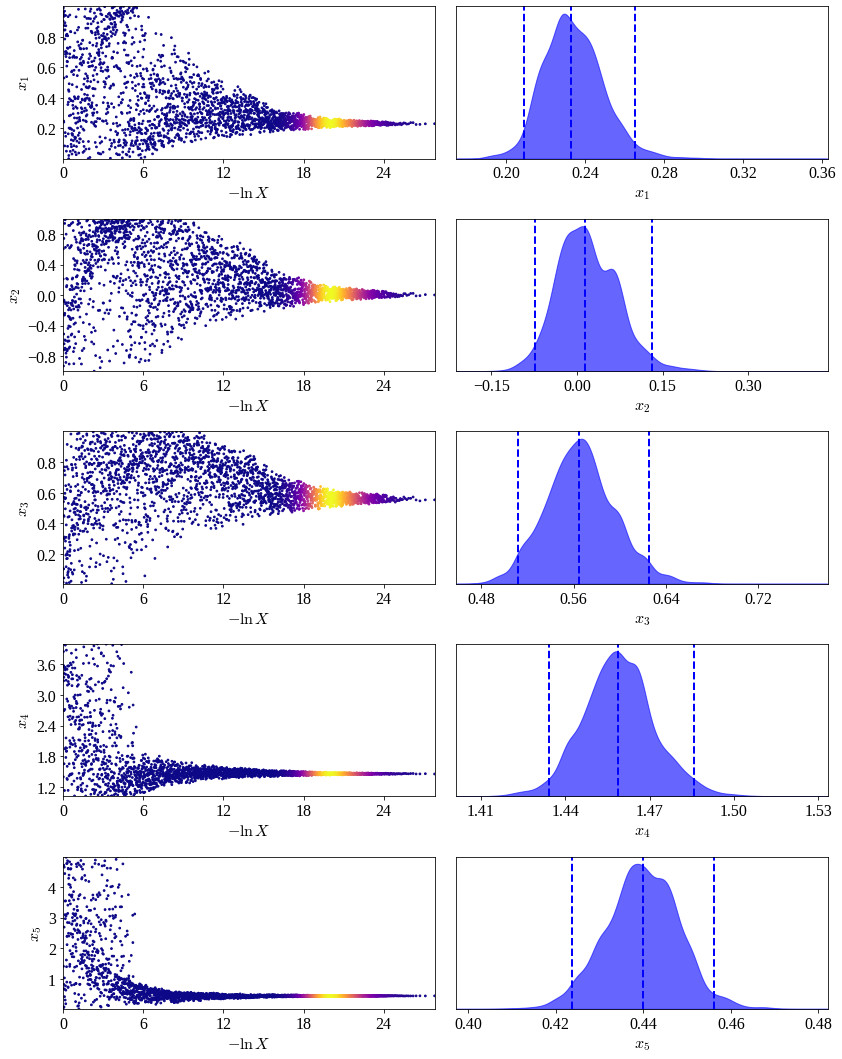

In [22]:
tfig, taxes = dyplot.traceplot(sresults)

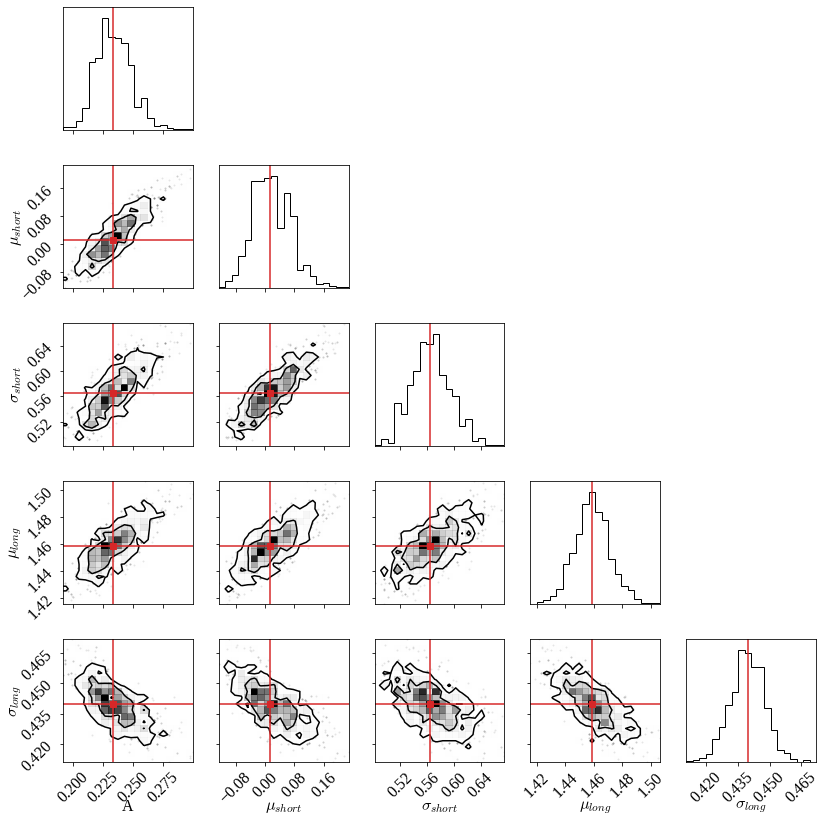

In [23]:
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights
samples_equal = dyfunc.resample_equal(samples, weights)

labels = ['A', r'$\mu_{short}$', r'$\sigma_{short}$',r'$\mu_{long}$', r'$\sigma_{long}$']

#compute median parameters
median_parameters = []
low_err = []
up_err = []
for i in range(5):
    low, med, up = np.percentile(samples_equal[:,i],[5,50, 95])
    median_parameters.append(med)
    low_err.append(med - low)
    up_err.append(up - med)
    
# Make the corner plot
figure = corner.corner(samples_equal, labels = labels, levels=[0.68,0.95], truths=median_parameters, truth_color='tab:red');

Text(0.5, 0, 'log(T90)')

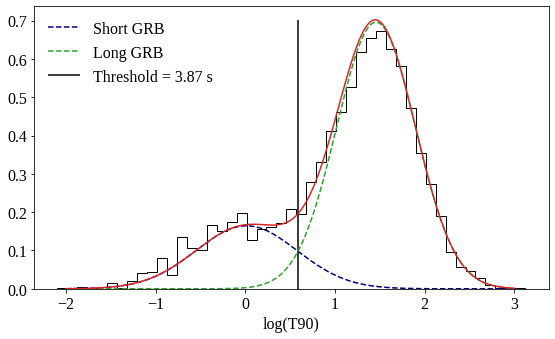

In [24]:
#plot the Gaussian mixture fit
_ = fancyhist(T90, bins = 'freedman', density=True, histtype = 'step', color = 'k');

x = np.linspace(-2, 3, 1000)
y_short = median_parameters[0]*scipy.stats.norm(median_parameters[1], scale=median_parameters[2]).pdf(x)
y_long = (1-median_parameters[0])*scipy.stats.norm(median_parameters[3], scale=median_parameters[4]).pdf(x)

plt.plot(x, y_short, label='Short GRB', c='navy', linestyle='--')
plt.plot(x, y_long, label='Long GRB', c='tab:green', linestyle='--')
plt.plot(x, y_short+y_long, c='tab:red')

#find the threshold as the intersection of the two individual distributions
diff = abs(y_long[x>0] - y_short[x>0])
thr_gmm = 10**x[int(np.argmin(abs(x)) + np.argmin(diff))]
plt.vlines(x=np.log10(thr_gmm), ymin=0,ymax=np.max(y_short+y_long), color='k', 
           label = 'Threshold = {:.2f} s'.format(thr_gmm))
plt.legend(frameon=False)
plt.xlabel(r'log(T90)')

### Try explore the z vs. T90 relation

Text(0.5, 0, 'z')

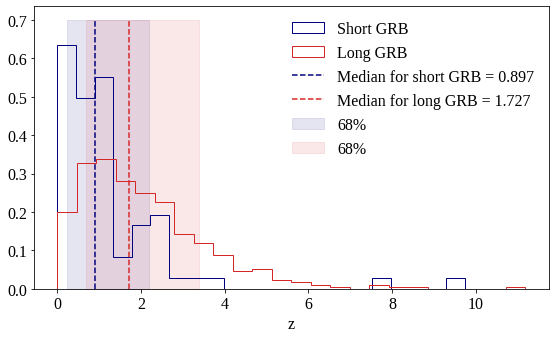

In [92]:
#select redshifts of short and long GRBs
z_short = z_unclean[T90_unclean != -999]
z_short = z_short[labels_ms == 0]
z_short = z_short[z_short > 0]
z_long = z_unclean[T90_unclean != -999]
z_long = z_long[labels_ms == 1]
z_long = z_long[z_long > 0]

#plot them
a0 = fancyhist(z_short, bins = 'freedman', density = True, histtype = 'step', color = 'w');
plt.hist(z_short, bins = a0[1], histtype = 'step', color = 'navy', density = True, label = 'Short GRB');
a0 = fancyhist(z_long, bins = 'freedman', density = True, histtype = 'step', color = 'w');
plt.hist(z_long, bins = a0[1], histtype = 'step', color = 'tab:red', density = True, label = 'Long GRB');
plt.vlines(x = np.median(z_short), ymin = 0, ymax = 0.7, color='navy', linestyle = '--', label = f'Median for short GRB = {np.median(z_short):.3f}')
plt.vlines(x = np.median(z_long), ymin = 0, ymax = 0.7, color='tab:red', linestyle = '--', label = f'Median for long GRB = {np.median(z_long):.3f}')
plt.fill_between(x = np.linspace(np.quantile(z_short, 0.16), np.quantile(z_short, 0.84), 100), y1 = 0, y2 = 0.7, edgecolor = 'None', color='navy',alpha = 0.1, label = f'68%')
plt.fill_between(x = np.linspace(np.quantile(z_long, 0.16), np.quantile(z_long, 0.84), 100), y1 = 0, y2 = 0.7, edgecolor = 'None', color='tab:red',alpha = 0.1, label = f'68%')

plt.legend(frameon = False)
plt.xlabel('z')

It seems that on average long GRBs are at higher redshifts than short GRBs, but the two median values are compatible with each other within 68% confidence level, so there's not any evidence